https://www.usitc.gov/data/gravity/gme_docs/estimation_tutorial/

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt 

import statsmodels.api as sm
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
gravd = pd.read_csv('/content/gdrive/MyDrive/gravity/gravd.csv')
gravd.columns

Index(['year', 'iso_o', 'iso_d', 'contig', 'comlang_off', 'distw', 'pop_o',
       'gdp_o', 'gdpcap_o', 'iso2_o', 'pop_d', 'gdp_d', 'gdpcap_d', 'iso2_d',
       'heg_d', 'conflict', 'indepdate', 'heg_o', 'col_to', 'col_fr',
       'col_hist', 'col_cur', 'sever', 'sib_conflict', 'gatt_o', 'gatt_d',
       'rta', 'comleg', 'comcur', 'acp_to_eu', 'gsp', 'eu_to_acp', 'gsp_rec',
       'flow', 'validmirror', 'family', 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

In [5]:
gravd = gravd[['flow', 'distw'
                     , 'gdp_o', 'gdp_d'
                     , 'contig', 'comlang_off', 'col_hist'
                     #, 'iso_o', 'iso_d'
                     #, 'gdpcap_o', 'gdpcap_d'
                     #, 'heg_o', 'heg_d'
                     #, 'gatt_o', 'gatt_d'
                     #, 'rta', 'comcur', 'family'
                     , 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'
                     ]]
gravd = gravd.dropna()

In [6]:
flow = np.array(gravd.flow.astype(np.float32))  
print('of', len(flow), 'observations'
      , len(flow) - np.count_nonzero(flow), ' are zero ='
      , (len(flow) - np.count_nonzero(flow))/ len(flow)*100, '%')

of 26967 observations 6970  are zero = 25.846404865205624 %


In [7]:
bins = np.geomspace(1, len(gravd), 100)
flowZ = flow.copy()
flowZ = np.digitize(flow, bins)

In [8]:
# weighted geographical between origin and destination
distw = np.array(gravd.distw.astype(np.float32))

# GDP of origin
gdp_o = np.array(gravd.gdp_o.astype(np.float32))

# GDP of destination
gdp_d = np.array(gravd.gdp_d.astype(np.float32))

# Dummies 
# neighbourhood status between origin and destination
contig = np.array(gravd.contig.astype(np.int8))
# common official language of origin and destination
comlang_off = np.array(gravd.comlang_off.astype(np.int8))
# colonial ties between origin and destination
col_hist = np.array(gravd.col_hist.astype(np.int8))
# island
isl_o = np.array(gravd.isl_o.astype(np.int8))
isl_d = np.array(gravd.isl_d.astype(np.int8))
# landlocked
lndl_o = np.array(gravd.lndl_o.astype(np.int8))
lndl_d = np.array(gravd.lndl_d.astype(np.int8))

X = np.array([flowZ, distw, gdp_o, gdp_d
              , contig, comlang_off, col_hist
              , isl_o, isl_d, lndl_o, lndl_d
              ]).T

In [9]:
# class for data preparation
class prepare_data:
    def __init__(self):
        self.X = X.copy()
        self.y = flow.copy()
        
    # train test split and transform
    def tts(self, rnd = 42):
         # train test split stratify on binary zero trade
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X[:,1:11], self.y
                                                                                , random_state=(rnd)
                                                                                , test_size=0.2
                                                                                , stratify=(self.X[:,0])
                                                                                )
        
# plot feature importance 
def plot_feature_importance(model):
    n_features = len(data.X_train[0,:])
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), feature_names) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")



In [10]:
data = prepare_data()
data.tts()

In [11]:
feature_names = gravd.columns[1:len(X[0,:])]
feature_names

Index(['distw', 'gdp_o', 'gdp_d', 'contig', 'comlang_off', 'col_hist', 'isl_o',
       'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

https://github.com/statsmodels/statsmodels/issues/4942
https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html
https://personal.lse.ac.uk/tenreyro/LGW.html?

In [12]:
mod = sm.GLM(data.y_train, data.X_train, family=sm.families.Poisson())

In [13]:
results = mod.fit(cov_type='HC1')
#results = mod.fit(cov_type='HC0')

In [14]:
# results = mod.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21573
Model:                            GLM   Df Residuals:                    21563
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7469e+07
Date:                Sat, 15 May 2021   Deviance:                   3.4885e+07
Time:                        20:45:25   Pearson chi2:                 2.90e+09
No. Iterations:                     9                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002   1.89e-05      9.780      0.0

In [15]:
feature_names

Index(['distw', 'gdp_o', 'gdp_d', 'contig', 'comlang_off', 'col_hist', 'isl_o',
       'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

In [16]:
params = results.params

compute R2

In [18]:
predict_oos = mod.predict(params, data.X_test)
predict_wis = mod.predict(params, data.X_train)

cor_oos = np.corrcoef(data.y_test, predict_oos)[1][0]
print('out of sample R2', cor_oos*cor_oos)

cor_wis = np.corrcoef(data.y_train, predict_wis)[1][0]
print('within sample R2', cor_wis*cor_wis)

out of sample R2 0.7400814311405779
within sample R2 0.5157339382705933


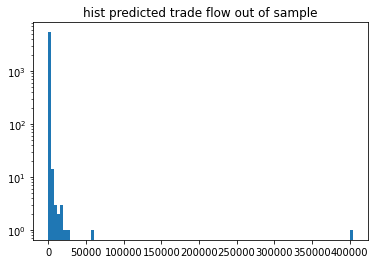

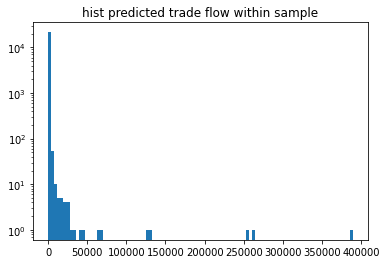

In [19]:
plt.hist(predict_oos, bins=100, log=True)
plt.title('hist predicted trade flow out of sample')
plt.show()
plt.hist(predict_wis, bins=100, log=True)
plt.title('hist predicted trade flow within sample')
plt.show()

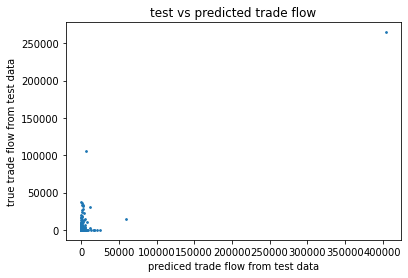

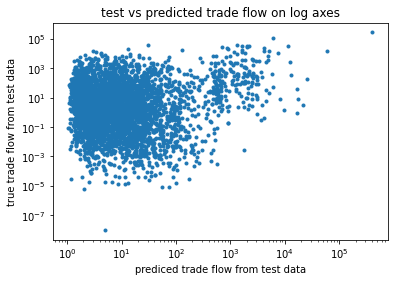

In [20]:
# plot y against y^
plt.scatter(predict_oos, data.y_test, s = 3)
plt.xlabel('prediced trade flow from test data')
plt.ylabel('true trade flow from test data')
plt.title('test vs predicted trade flow')
plt.show()
# plot y against y^ on log axes
plt.loglog(predict_oos, data.y_test, marker = 'o', markersize = 3, linestyle = '')
plt.xlabel('prediced trade flow from test data')
plt.ylabel('true trade flow from test data')
plt.title('test vs predicted trade flow on log axes')
plt.show()

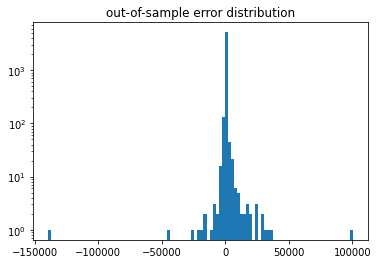

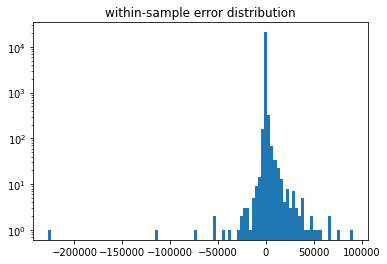

In [21]:
# out-of-sample errors
oos_errors = data.y_test - predict_oos
plt.hist(oos_errors, bins=100, log=True)
plt.title('out-of-sample error distribution')
plt.show()
# within-sample errors
is_prediction = mod.predict(params, data.X_train)
is_errors = data.y_train - is_prediction
plt.hist(is_errors, bins=100, log=True)
plt.title('within-sample error distribution')
plt.show()

random validation loop

In [22]:
all_r2_test = []
for i in range(100):
  data.tts(rnd=None)
  mod = sm.GLM(data.y_train, data.X_train, family=sm.families.Poisson())
  mod.fit(cov_type='HC1')

  predict_oos = mod.predict(params, data.X_test)
  predict_wis = mod.predict(params, data.X_train)

  cor_oos = np.corrcoef(data.y_test, predict_oos)[1][0]
  cor_wis = np.corrcoef(data.y_train, predict_wis)[1][0]
  
  r2_test = cor_oos*cor_oos
  
  all_r2_test.append(r2_test)
  print('R2 test:', r2_test)
  print('R2 train', cor_wis*cor_wis)
print('mean R2 test:', np.mean(all_r2_test))


R2 test: 0.06149543610636213
R2 train 0.64436849579187
R2 test: 0.790585807651109
R2 train 0.35164398657995355
R2 test: 0.4767756410329245
R2 train 0.6244938247232416
R2 test: 0.516111191227965
R2 train 0.5958192792884521
R2 test: 0.24650661980468727
R2 train 0.6114043553359138
R2 test: 0.2952062564992763
R2 train 0.6042229810045798
R2 test: 0.24938831571925363
R2 train 0.613596448456819
R2 test: 0.7832035210277478
R2 train 0.501569011997855
R2 test: 0.7730955680885097
R2 train 0.5264131879348793
R2 test: 0.6106835489232203
R2 train 0.599171476451351
R2 test: 0.7523842744044342
R2 train 0.4923888261123389
R2 test: 0.026207219399280154
R2 train 0.6293872848219585
R2 test: 0.6592975009561006
R2 train 0.5675030597856813
R2 test: 0.19760159879335804
R2 train 0.626986661269516
R2 test: 0.7234659692235225
R2 train 0.49460557010497097
R2 test: 0.6146253376126962
R2 train 0.5806777657684766
R2 test: 0.751083278410763
R2 train 0.48029462790696614
R2 test: 0.7458586227919787
R2 train 0.505839121